## Example Environment: Blackjack

We'll use a simplified version of Blackjack as our environment. This is a classic example for MC methods because:
- Episodes naturally terminate (game ends)
- The environment dynamics are complex but we can simulate games
- We don't need to know the exact probability of each card

### Game Rules (Simplified):
- Goal: Get cards summing as close to 21 as possible without going over
- Face cards count as 10, Aces can count as 1 or 11
- Player starts with 2 cards, dealer shows 1 card
- Player can **hit** (take another card) or **stick** (stop taking cards)
- If player goes over 21, they lose (bust)
- If player sticks, dealer plays (hits until sum ≥ 17)
- Winner is whoever is closer to 21 without busting


### Use the following link to know more about blackjack
https://youtu.be/PljDuynF-j0?si=yxH9uj4SzbNQP24d <br>
https://www.youtube.com/watch?v=DeazgPwP3D0 (Personal favourite)

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from collections import defaultdict
import seaborn as sns
from tqdm import tqdm

np.random.seed(17)
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (6,4)

In [ ]:
class BlackjackEnvironment:

  def __init__(self):
    self.action_space = [0, 1]

  def draw_card(self):
    card = min(np.random.randint(1, 14), 10)
    return card

  def draw_hand(self):
    return [self.draw_card(), self.draw_card()]

  def usable_ace(self, hand):
    return 1 in hand and sum(hand) + 10 <= 21

  def sum_hand(self, hand):
    if self.usable_ace(hand):
      return sum(hand) + 10
    return sum(hand)

  def is_bust(self, hand):
    return self.sum_hand(hand) > 21

  def reset(self):
    self.player_hand = self.draw_hand()
    self.dealer_hand = self.draw_hand()

    while self.sum_hand(self.player_hand) < 12:
      self.player_hand.append(self.draw_card())

    return self._get_state()

  def _get_state(self):
    return (
        self.sum_hand(self.player_hand),
        self.dealer_hand[0],
        self.usable_ace(self.player_hand)
    )

  def step(self, action):
    if action == 1:
      self.player_hand.append(self.draw_card())
      if self.is_bust(self.player_hand):
        return self._get_state(), -1, True
      else:
        return self._get_state(), 0, False
    else:
      while self.sum_hand(self.dealer_hand) < 17:
        self.dealer_hand.append(self.draw_card())
      player_sum = self.sum_hand(self.player_hand)
      dealer_sum = self.sum_hand(self.dealer_hand)
      if self.is_bust(self.dealer_hand):
        reward = 1
      elif player_sum > dealer_sum:
        reward = 1
      elif player_sum == dealer_sum:
        reward = 0
      else:
        reward = -1
      return self._get_state(), reward, True

# Testing the Environment
Let's simulate a few games with a random policy to understand the environment

In [ ]:
def simulate_random_episode(env):
  state = env.reset()
  episode = []
  done = False
  while not done:
    action = np.random.choice(env.action_space)
    next_state, reward, done = env.step(action)
    action_name = "STICK" if action == 0 else "HIT"
    print(f"Player sum: {state[0]}, dealer showing: {state[1]}, usable ace: {state[2]}, action: {action_name}")
    state = next_state
    episode.append((state, action, reward))
  final_reward = episode[-1][-1]
  return episode, final_reward

In [ ]:
n_episodes_to_simulate = 2
env = BlackjackEnvironment()
for i in range(n_episodes_to_simulate):
  episode, final_reward = simulate_random_episode(env)
  print(f"Episode {i+1} finished with reward {final_reward}")

Player sum: 20, dealer showing: 7, usable ace: True, action: HIT
Player sum: 17, dealer showing: 7, usable ace: False, action: HIT
Episode 1 finished with reward -1
Player sum: 13, dealer showing: 10, usable ace: False, action: HIT
Player sum: 15, dealer showing: 10, usable ace: False, action: HIT
Episode 2 finished with reward -1


Before doing control, let's implement MC prediction to evaluate a policy. We'll use first-visit MC to estimate the action-value function $Q(s, a)$.

### Algorithm:
1. Initialize $Q(s, a)$ arbitrarily
2. Initialize Returns(s, a) as empty list for all state-action pairs
3. Repeat for many episodes:
   - Generate episode following policy π
   - For each state-action pair (s, a) in the episode:
     - G ← return following first occurrence of (s, a)
     - Append G to Returns(s, a)
     - Q(s, a) ← average(Returns(s, a))

In [ ]:
def generate_epsiode(env, policy):
  episode = []
  state = env.reset()
  done=False

  while not done:
    action = policy.get(state, np.random.choice([0, 1]))
    next_state, reward, done = env.step(action)
    episode.append([state, action, reward])
    state = next_state

  return episode

def mc_prediction(env, policy, num_episodes, gamma=1.0):
  Q = defaultdict(float)
  returns_sum = defaultdict(float)
  returns_count = defaultdict(float)

  for episode_num in range(num_episodes):
    episode = generate_epsiode(env, policy)
    visited = set()
    returns = [0.0]*len(episode)
    G = 0
    for t in range(len(episode)-1, -1, -1):
      _, _, reward = episode[t]
      G = gamma*G + reward
      returns[t] = G
    for t in range(len(episode)):
      state, action, _ = episode[t]
      if (state, action) not in visited:
        visited.add((state, action))
        returns_sum[(state, action)] += returns[t]
        returns_count[(state, action)] += 1
        Q[(state, action)] = returns_sum[(state, action)]/returns_count[(state, action)]
    if (episode_num + 1) % 2000 == 0:
      print(f"Completed {episode_num + 1} episodes")
  return Q


We can test our *First-visit* MC prediction implementation using a simple policy

In [17]:
example_policy = {}
for player_sum in range(12, 22):
  for dealer_card in range(1, 11):
    for usable_ace in [True, False]:
      state = (player_sum, dealer_card, usable_ace)
      example_policy[state] = 0 if player_sum >= 20 else 1

print("Evaluating example policy...")
env = BlackjackEnvironment()
Q = mc_prediction(env, example_policy, num_episodes=10000)

Evaluating example policy...
Completed 2000 episodes
Completed 4000 episodes
Completed 6000 episodes
Completed 8000 episodes
Completed 10000 episodes


Now we implement MC control to find the optimal policy. We use **ε-greedy exploration** to ensure we explore all state-action pairs while mostly exploiting the best known actions.

### ε-Greedy Policy:
- With probability 1-ε: choose the greedy action (argmax Q(s, a))
- With probability ε: choose a random action

### Algorithm (On-Policy First-Visit MC Control):
1. Initialize Q(s, a) arbitrarily
2. Initialize π to be ε-greedy with respect to Q
3. Repeat for many episodes:
   - Generate episode using π
   - For each (s, a) in episode:
     - Update Q(s, a) using returns
     - Update π to be ε-greedy with respect to new Q

In [36]:
def epsilon_greedy_policy(Q, state, epsilon=0.1):
  if np.random.random() < epsilon:
    return np.random.choice([0, 1])
  else:
    try:
      q_values = [Q.get((state, a)) for a in [0, 1]]
      return np.argmax(q_values)
    except:
      return np.random.choice([0, 1])

def generate_episode_epsilon_greedy(env, Q, epsilon=0.1):
  episode = []
  state = env.reset()
  done = False

  while not done:
      action = epsilon_greedy_policy(Q, state, epsilon)
      next_state, reward, done = env.step(action)
      episode.append((state, action, reward))
      state = next_state

  return episode

def mc_control_epsilon_greedy(env, num_episodes=500000, gamma=1.0, epsilon=0.1):

    Q = defaultdict(float)
    returns_sum = defaultdict(float)
    returns_count = defaultdict(int)
    returns_history = []

    for episode_num in tqdm(range(num_episodes)):

        episode = generate_episode_epsilon_greedy(env, Q, epsilon)
        episode_return = sum([x[2] for x in episode])
        returns_history.append(episode_return)

        G = 0
        visited = set()

        returns = [0.0]*len(episode)
        for t in range(len(episode)-1, -1, -1):
          _, _, reward = episode[t]
          G = gamma*G + reward
          returns[t] = G

        for t in range(len(episode)):
          state, action, _ = episode[t]
          if (state, action) not in visited:
            visited.add((state, action))
            returns_sum[(state, action)] += returns[t]
            returns_count[(state, action)] += 1
            Q[(state, action)] = returns_sum[(state, action)]/returns_count[(state, action)]

        if (episode_num + 1) % 50000 == 0:
            avg_return = np.mean(returns_history[-10000:])
            print(f"Episode {episode_num + 1}/{num_episodes}, Avg return (last 10k): {avg_return:.3f}")

    policy = {}
    for state in set([s for s, _ in Q.keys()]):
        q_values = [Q.get((state, a), 0.0) for a in [0, 1]]
        policy[state] = np.argmax(q_values)

    return Q, policy, returns_history


In [37]:
print("Training MC Control agent...\n")
env = BlackjackEnvironment()
Q_optimal, optimal_policy, returns_history = mc_control_epsilon_greedy(
    env,
    num_episodes=500000,
    epsilon=0.1
)

print(f"\nTraining complete!")
print(f"Learned {len(Q_optimal)} state-action values")
print(f"Policy defined for {len(optimal_policy)} states")

Training MC Control agent...



 11%|█         | 53040/500000 [00:03<00:24, 18061.49it/s]

Episode 50000/500000, Avg return (last 10k): -0.094


 21%|██        | 104671/500000 [00:06<00:23, 16685.79it/s]

Episode 100000/500000, Avg return (last 10k): -0.083


 31%|███       | 152648/500000 [00:09<00:21, 15945.27it/s]

Episode 150000/500000, Avg return (last 10k): -0.083


 41%|████      | 203931/500000 [00:12<00:15, 19036.51it/s]

Episode 200000/500000, Avg return (last 10k): -0.096


 51%|█████     | 252853/500000 [00:14<00:14, 17423.70it/s]

Episode 250000/500000, Avg return (last 10k): -0.093


 61%|██████    | 303415/500000 [00:17<00:12, 15966.10it/s]

Episode 300000/500000, Avg return (last 10k): -0.076


 71%|███████   | 353262/500000 [00:20<00:08, 16436.84it/s]

Episode 350000/500000, Avg return (last 10k): -0.068


 80%|████████  | 401548/500000 [00:23<00:06, 15064.88it/s]

Episode 400000/500000, Avg return (last 10k): -0.081


 91%|█████████ | 455292/500000 [00:27<00:02, 17636.90it/s]

Episode 450000/500000, Avg return (last 10k): -0.089


100%|██████████| 500000/500000 [00:29<00:00, 16801.71it/s]

Episode 500000/500000, Avg return (last 10k): -0.071

Training complete!
Learned 400 state-action values
Policy defined for 200 states


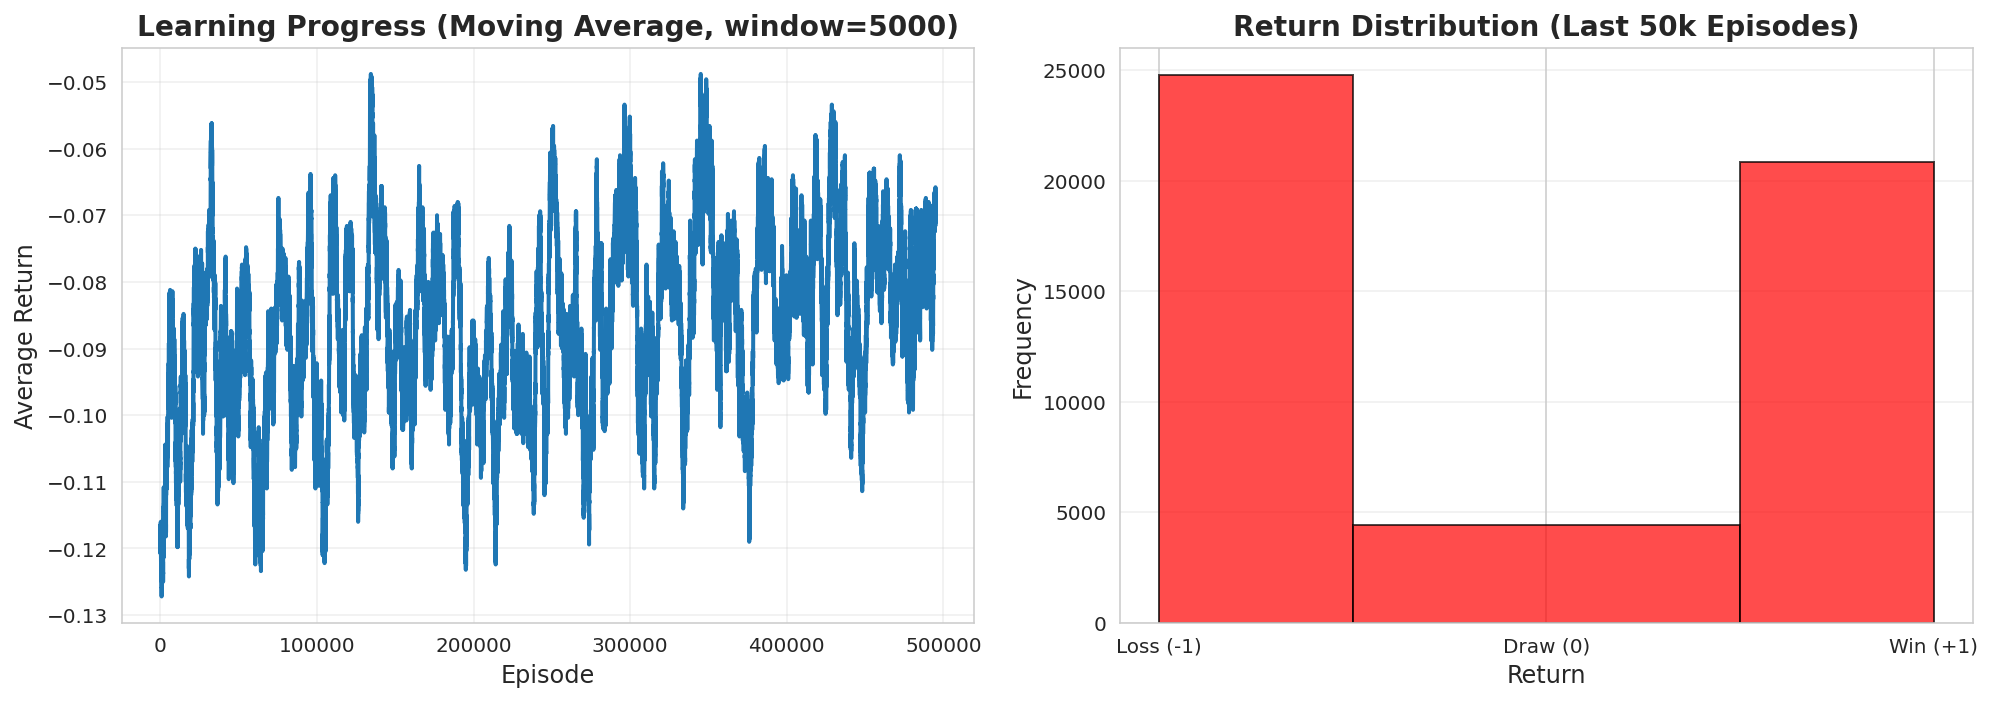


Final Performance (last 50k episodes):
  Win rate:  41.6%
  Loss rate: 49.5%
  Draw rate: 8.8%
  Average return: -0.079


In [40]:
window_size = 5000
moving_avg = np.convolve(returns_history, np.ones(window_size)/window_size, mode='valid')

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(moving_avg, linewidth=2)
plt.xlabel('Episode', fontsize=12)
plt.ylabel('Average Return', fontsize=12)
plt.title(f'Learning Progress (Moving Average, window={window_size})', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(returns_history[-50000:], bins=[-1, -0.5, 0.5, 1],
         color=['red'], alpha=0.7, edgecolor='black')
plt.xlabel('Return', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Return Distribution (Last 50k Episodes)', fontsize=14, fontweight='bold')
plt.xticks([-1, 0, 1], ['Loss (-1)', 'Draw (0)', 'Win (+1)'])
plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

final_returns = returns_history[-50000:]
win_rate = (np.array(final_returns) > 0).mean()
loss_rate = (np.array(final_returns) < 0).mean()
draw_rate = (np.array(final_returns) == 0).mean()

print(f"\nFinal Performance (last 50k episodes):")
print(f"  Win rate:  {win_rate:.1%}")
print(f"  Loss rate: {loss_rate:.1%}")
print(f"  Draw rate: {draw_rate:.1%}")
print(f"  Average return: {np.mean(final_returns):.3f}")

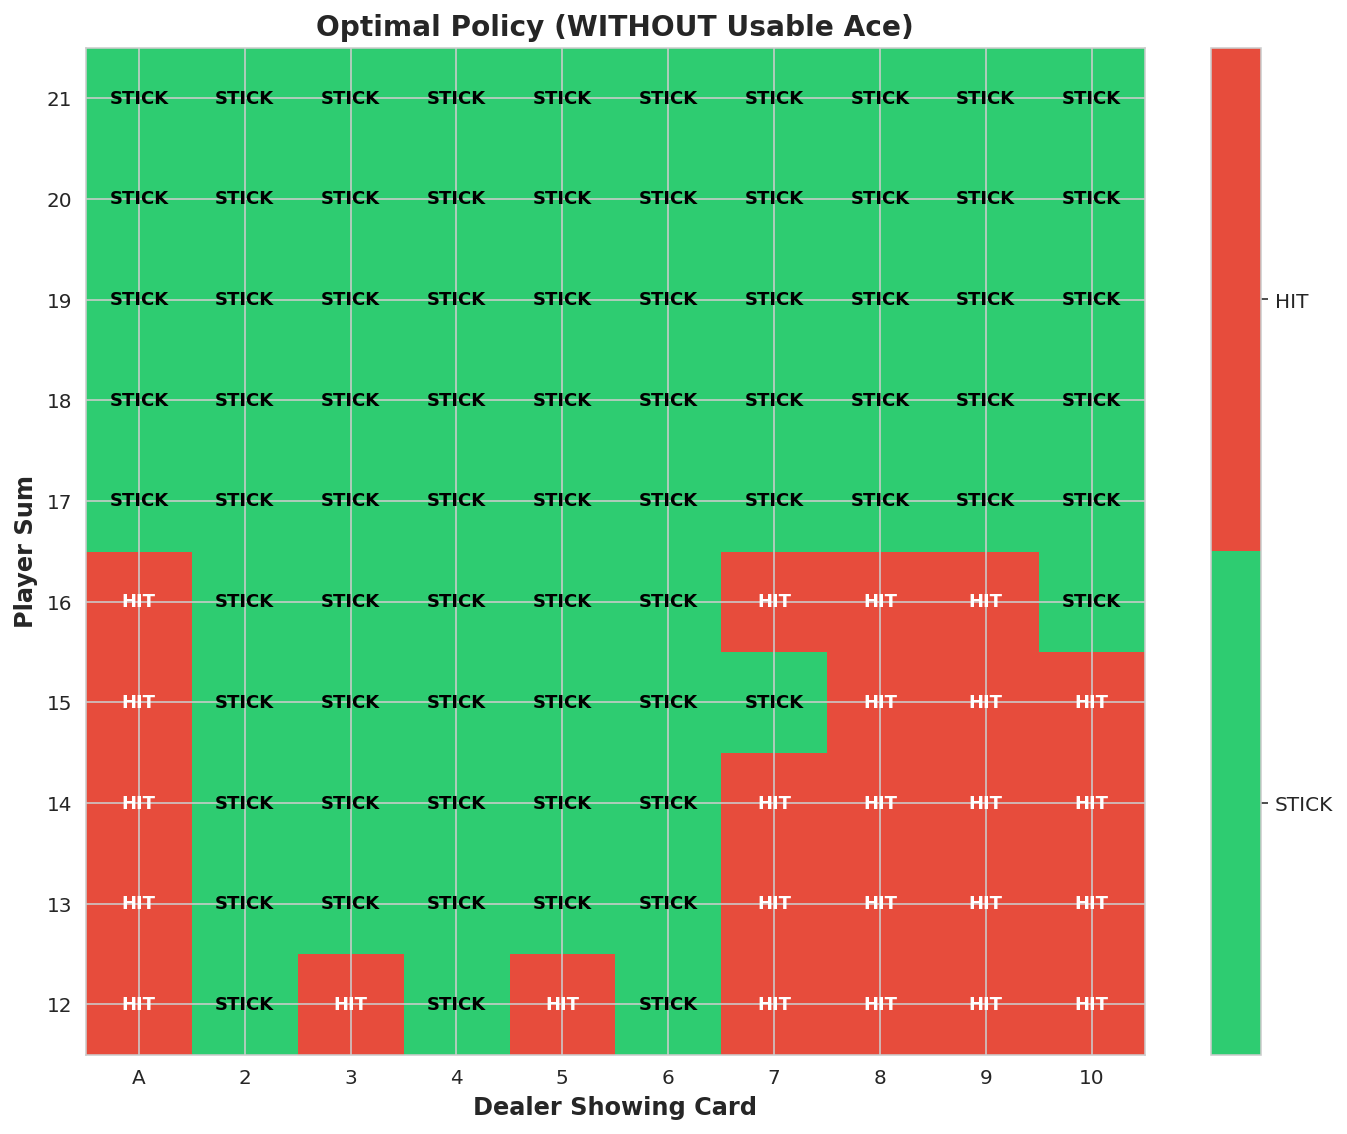

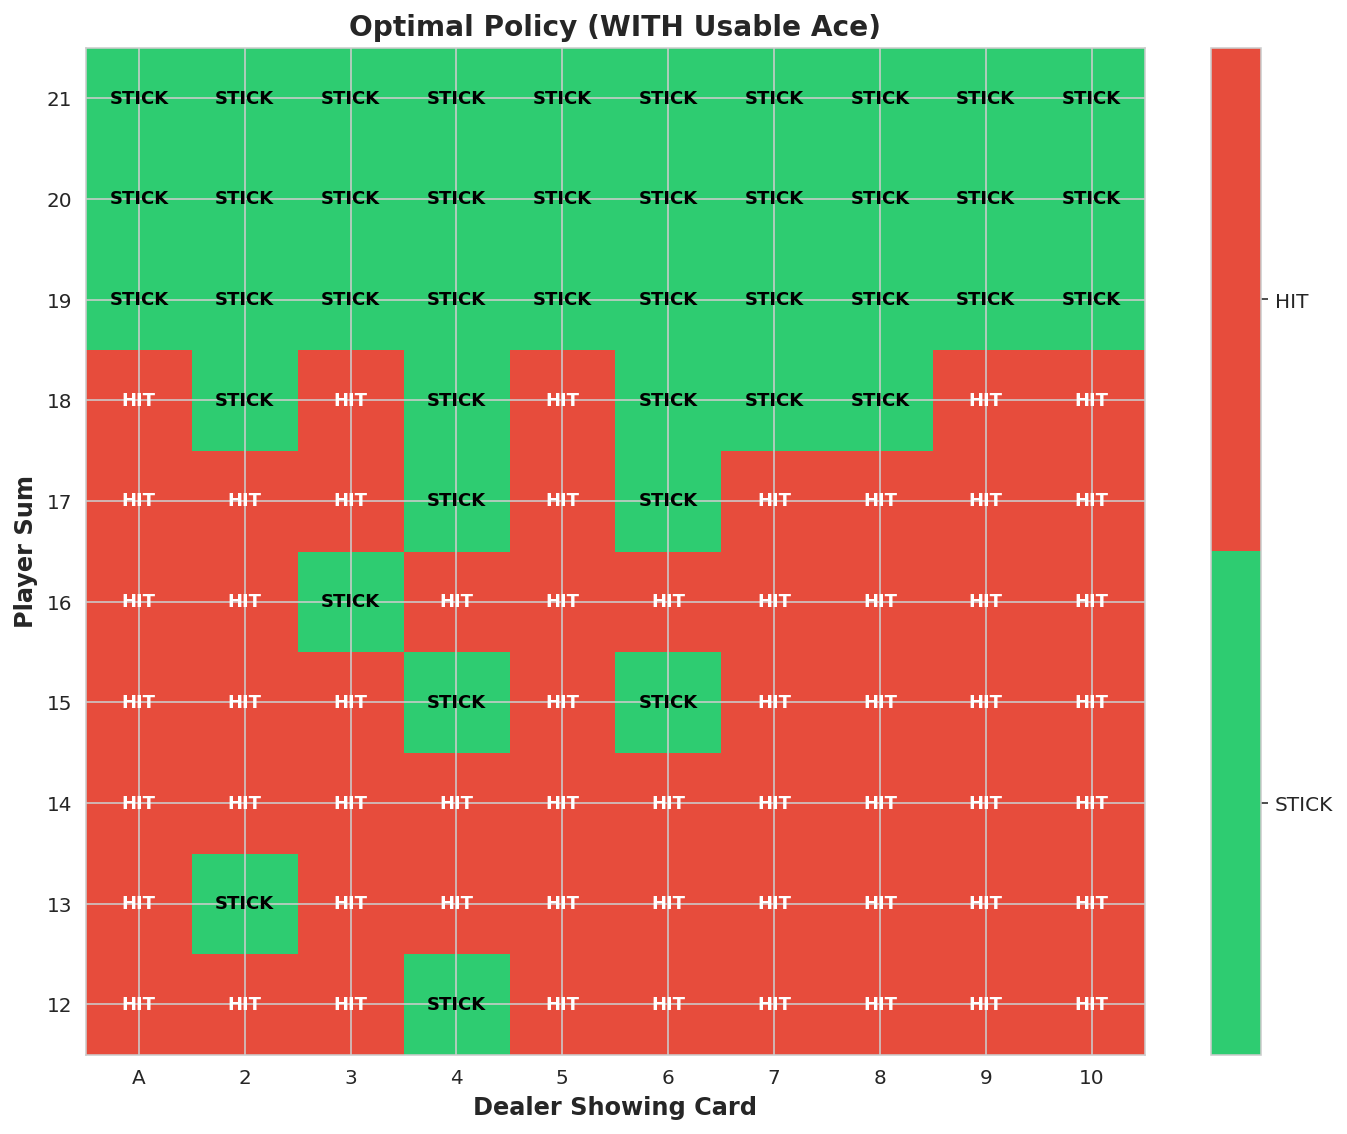

In [42]:
def plot_policy(policy, usable_ace=False):
    policy_grid = np.zeros((10, 10))
    for player_sum in range(12, 22):
        for dealer_card in range(1, 11):
            state = (player_sum, dealer_card, usable_ace)
            action = policy.get(state, 0)
            policy_grid[player_sum - 12, dealer_card - 1] = action

    plt.figure(figsize=(10, 8))

    cmap = plt.cm.colors.ListedColormap(['#2ecc71', '#e74c3c'])

    im = plt.imshow(policy_grid, cmap=cmap, aspect='auto', origin='lower', vmin=0, vmax=1)

    for i in range(10):
        for j in range(10):
            text = "STICK" if policy_grid[i, j] == 0 else "HIT"
            color = "white" if policy_grid[i, j] == 1 else "black"
            plt.text(j, i, text, ha="center", va="center",
                    color=color, fontsize=9, fontweight='bold')

    plt.xlabel('Dealer Showing Card', fontsize=12, fontweight='bold')
    plt.ylabel('Player Sum', fontsize=12, fontweight='bold')

    ace_text = "WITH" if usable_ace else "WITHOUT"
    plt.title(f'Optimal Policy ({ace_text} Usable Ace)', fontsize=14, fontweight='bold')

    plt.xticks(range(10), ['A', '2', '3', '4', '5', '6', '7', '8', '9', '10'])
    plt.yticks(range(10), range(12, 22))

    cbar = plt.colorbar(im, ticks=[0.25, 0.75])
    cbar.ax.set_yticklabels(['STICK', 'HIT'])

    plt.tight_layout()
    plt.show()

plot_policy(optimal_policy, usable_ace=False)
plot_policy(optimal_policy, usable_ace=True)

Key Insights from the Learned Policy

### General Strategy:
1. **High player sum (19-21)**: Almost always stick, regardless of dealer's card
2. **Medium player sum (17-18)**: Strategy depends on dealer's card
   - Stick against weak dealer cards (2-6)
   - Sometimes hit against strong dealer cards (7-10, A)
3. **Low player sum (12-16)**: Usually hit, especially against strong dealer cards
4. **With usable ace**: More aggressive (hit more often) since going bust is impossible

### Why This Makes Sense:
- **Dealer is forced to hit until 17+**, so:
  - Weak dealer cards (2-6) have higher bust probability
  - Strong dealer cards (7-A) are more likely to result in 17-21
- **Usable ace provides safety**: Can hit without fear of busting
- **Value function shows**: States with high player sum or weak dealer card have higher value